In [19]:
import os

In [20]:
os.chdir('/home/witoslaw/data/diffTSS')
os.getcwd()

'/home/witoslaw/data/diffTSS'

In [21]:
from EPInformer.models import EPInformer_v2, enhancer_predictor_256bp
from scripts.utils import prepare_input, prepare_hd5_input, FastaStringExtractor, one_hot_encode
from sklearn.preprocessing import StandardScaler
import scripts.utils_forTraining as train
import kipoiseq
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from tqdm import tqdm
import torch
import glob
from torch.utils.data import Subset, Dataset
import h5py
import matplotlib.pyplot as plt

In [22]:
os.listdir('./')

['ABC-multiTSS_nominated',
 'CRISPRi-FlowFISH_Fulco2019',
 'GM12878_K562_18377_gene_expr_fromXpresso.csv',
 'GM12878_enhancer_gene_links_100kb.hg38.tsv',
 'GM12878_enhancer_promoter_encoding.hg38.h5',
 'GM12878_enhancer_promoter_encoding.rna_embedding.hg38.h5',
 'GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5',
 'K562_enhancer_gene_links_100kb.hg38.tsv',
 'K562_enhancer_promoter_encoding.hg38.h5',
 'K562_enhancer_promoter_encoding.rna_embedding.hg38.h5',
 'K562_enhancer_promoter_encoding.rna_encoding.hg38.h5',
 'RNASeq_bw',
 'RNA_CAGE.txt',
 'command.CAGE.sh',
 'command.RNAseq.sh',
 'command.Xpresso.sh',
 'download_EPInformer_training_data.sh',
 'download_abc_data.sh',
 'hg38.fa',
 'hg38.fa.fai',
 'leave_chrom_out_crossvalidation_split_18377genes.csv',
 'mRNA_halflife_features.csv',
 'replaceID.Xpresso.py',
 '.ipynb_checkpoints',
 'K562_GeneList_Genes.txt',
 'GM12878_GeneList_Genes.txt',
 'correlation.ipynb',
 'plots',
 'plus_minus_rna.py']

---
# Process K562 data

In [ ]:
enhancer_gene_k562_100kb = pd.read_csv('./K562_enhancer_gene_links_100kb.hg38.tsv', sep='\t')
gene_k562_tss = pd.read_csv('./ABC-multiTSS_nominated/K562/Neighborhoods/GeneList.txt', sep='\t')[['name', 'Ensembl_ID', 'chr', 'tss', 'strand', 'H3K27ac.RPM.TSS1Kb', 'DHS.RPM.TSS1Kb']]
gene_k562_tss['ENSID'] = gene_k562_tss['Ensembl_ID']

enhancer_gene_k562_100kb_includeNoEnhancerGene = enhancer_gene_k562_100kb.merge(gene_k562_tss, left_on='TargetGeneEnsembl_ID', right_on='Ensembl_ID', how='right', suffixes=['', '_gene']).reset_index()

gene_list = ['ENSG00000089327_2', 'ENSG00000143106', 'ENSG00000213934', 'ENSG00000196565', 'ENSG00000251562_2']

rna_df_K562 = pd.read_csv('./RNASeq_bw/K562.unstranded.ENCFF448XCV.coverage.txt', header=None, sep='\t')

In [ ]:
gene_list, PE_code_list, PE_distance_list, PE_activity_list, PE_contact_list, rna_df_list  = prepare_hd5_input(enhancer_gene_k562_100kb_includeNoEnhancerGene, gene_k562_tss, gene_list, 'K562', num_features=3, rna_method='encoding', rna_df=rna_df_K562)

In [ ]:
for i, gene in enumerate(gene_list):
    plt.plot(rna_df_list[i])
    plt.title(gene)
    plt.show()

--- 
# Process GM12878 data

In [ ]:
enhancer_gene_gm12878_100kb[enhancer_gene_gm12878_100kb['TargetGeneEnsembl_ID'].str.contains('ENSG00000251562')]['TargetGeneTSS'].unique()

In [ ]:
np.array(rna_dict['stranded'][(rna_dict['stranded'][0] == 'chr11') & 
                     (rna_dict['stranded'][7] > 65497606) & 
                     (rna_dict['stranded'][8] < 65508073)][7])

In [ ]:
grouped_df = rna_df[rna_df[7].duplicated(keep=False)].groupby(7)

for key, item in grouped_df:
    if len(grouped_df.get_group(key)[9].unique()) > 1:
        print(grouped_df.get_group(key)[9].unique(), "\n\n")

In [149]:
enhancer_gene_gm12878_100kb = pd.read_csv('./GM12878_enhancer_gene_links_100kb.hg38.tsv', sep='\t')
gene_gm12878_tss = pd.read_csv('./ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt', sep='\t')[['name', 'Ensembl_ID', 'chr', 'tss', 'strand', 'H3K27ac.RPM.TSS1Kb', 'DHS.RPM.TSS1Kb']]
gene_gm12878_tss['ENSID'] = gene_gm12878_tss['Ensembl_ID']

enhancer_gene_gm12878_100kb_includeNoEnhancerGene = enhancer_gene_gm12878_100kb.merge(gene_gm12878_tss, left_on='TargetGeneEnsembl_ID', right_on='Ensembl_ID', how='right', suffixes=['', '_gene']).reset_index()

#rna_df_GM12878 = pd.read_csv('./RNASeq_bw/GM12878.stranded.ENCFF074SXQ.ENCFF164VLA.coverage.txt', header=None, sep='\t')
rna_dict = {}
rna_dict['stranded'] = pd.read_csv('./RNASeq_bw/GM12878.stranded.ENCFF182LTN.ENCFF546NVF.coverage.txt', header=None, sep='\t')
rna_dict['plus'] = pd.read_csv('./RNASeq_bw/GM12878.plus.ENCFF182LTN.coverage.txt', header=None, sep='\t')
rna_dict['minus'] = pd.read_csv('./RNASeq_bw/GM12878.minus.ENCFF546NVF.coverage.txt', header=None, sep='\t')
#rna_dict['unstranded'] = pd.read_csv('./RNASeq_bw/GM12878.unstranded.ENCFF104OTO.coverage.txt', header=None, sep='\t')

In [104]:
enhancer_gene_gm12878_100kb.columns

Index(['index', 'chr', 'start', 'end', 'name', 'class', 'activity_base',
       'activity_base_enh', 'activity_base_squared_enh', 'normalized_dhs_enh',
       'normalized_h3k27ac_enh', 'TargetGene', 'TargetGeneTSS',
       'TargetGeneExpression', 'TargetGenePromoterActivityQuantile',
       'TargetGeneIsExpressed', 'TargetGeneEnsembl_ID', 'normalized_dhs_prom',
       'normalized_h3k27ac_prom', 'distance', 'isSelfPromoter',
       'powerlaw_contact', 'powerlaw_contact_reference', 'hic_contact',
       'hic_contact_pl_scaled', 'hic_pseudocount', 'hic_contact_pl_scaled_adj',
       'ABC.Score.Numerator', 'ABC.Score', 'powerlaw.Score.Numerator',
       'powerlaw.Score', 'CellType', 'hic_contact_squared'],
      dtype='object')

In [158]:
gene_list = ['ENSG00000089327_2', 'ENSG00000143106', 'ENSG00000213934', 'ENSG00000196565', 'ENSG00000251562_2']
gene_list = ['ENSG00000251562', 'ENSG00000251562_1', 'ENSG00000251562_2', 'ENSG00000251562_3', 'ENSG00000251562_4'] 
gene = 'ENSG00000251562'
num_TSS = !grep {gene} RNA_CAGE.txt | wc -l
num_TSS = int(num_TSS[0])
gene_list = [f'{gene}_{x}' if x > 0 else gene for x in range(num_TSS)]

In [159]:
chrom = enhancer_gene_gm12878_100kb[enhancer_gene_gm12878_100kb['TargetGeneEnsembl_ID'].str.contains(gene)][['chr']].drop_duplicates().iloc[0, 0]
chrom

'chr11'

In [160]:
TSSs = enhancer_gene_gm12878_100kb[enhancer_gene_gm12878_100kb['TargetGeneEnsembl_ID'].str.contains(gene)][['TargetGeneEnsembl_ID', 'TargetGeneTSS']].drop_duplicates()
TSSs

,TargetGeneEnsembl_ID,TargetGeneTSS
113804,ENSG00000251562,65497708
113805,ENSG00000251562_1,65498210
113819,ENSG00000251562_2,65499045
113820,ENSG00000251562_3,65502614
113836,ENSG00000251562_4,65503699


In [161]:
rna_dict[key][rna_dict[key][3].str.contains(gene)]

,0,1,2,3,4,5,6,7,8,9
2213312,chr11,65496708,65498708,ENSG00000251562,0,+,chr11,65496708,65496709,0.00552
2213313,chr11,65496708,65498708,ENSG00000251562,0,+,chr11,65496709,65496710,0.00552
2213314,chr11,65496708,65498708,ENSG00000251562,0,+,chr11,65496710,65496711,0.00552
2213315,chr11,65496708,65498708,ENSG00000251562,0,+,chr11,65496711,65496712,0.00552
2213316,chr11,65496708,65498708,ENSG00000251562,0,+,chr11,65496712,65496713,0.00552
...,...,...,...,...,...,...,...,...,...,...
2219332,chr11,65502699,65504699,ENSG00000251562_4,0,+,chr11,65504694,65504695,0.71249
2219333,chr11,65502699,65504699,ENSG00000251562_4,0,+,chr11,65504695,65504696,0.71249
2219334,chr11,65502699,65504699,ENSG00000251562_4,0,+,chr11,65504696,65504697,0.71249
2219335,chr11,65502699,65504699,ENSG00000251562_4,0,+,chr11,65504697,65504698,0.71249


TSSs of ENSG00000251562 stranded:


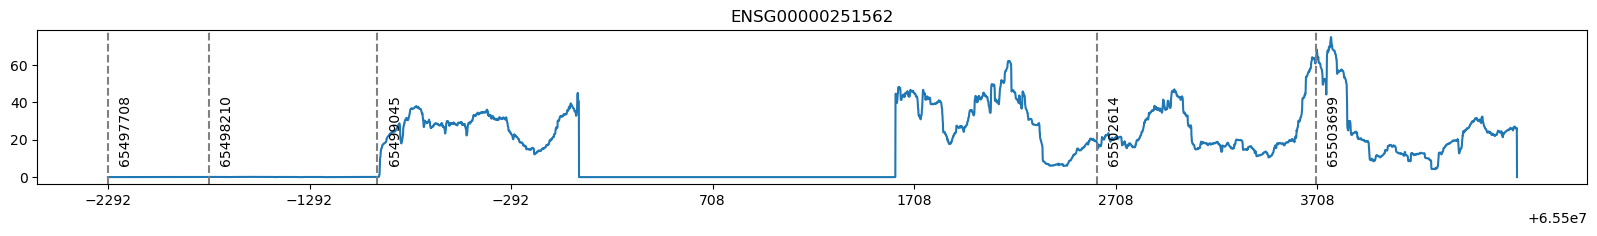

TSSs of ENSG00000251562 plus:


<Figure size 640x480 with 0 Axes>

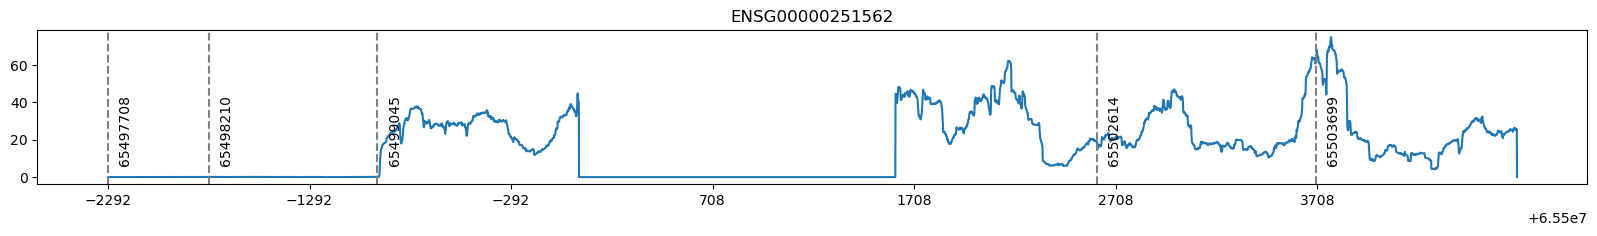

TSSs of ENSG00000251562 minus:


<Figure size 640x480 with 0 Axes>

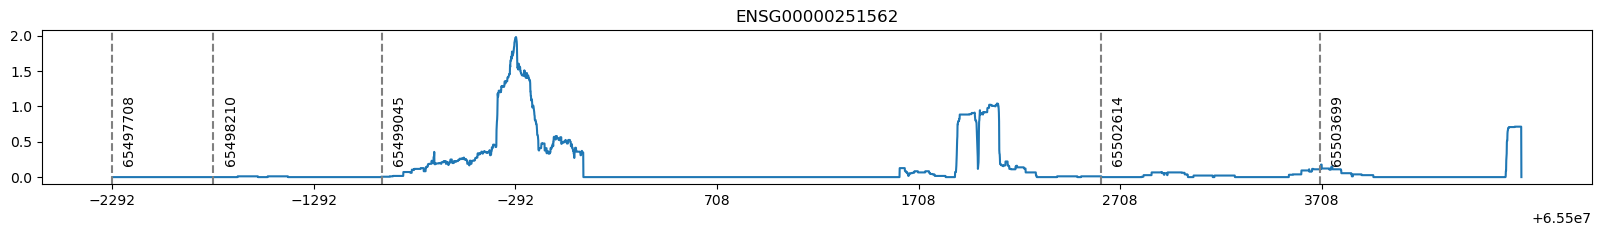

<Figure size 640x480 with 0 Axes>

In [166]:
for key in [key for key in rna_dict.keys() if 'unstranded' not in key]:
    TSS = TSS = enhancer_gene_gm12878_100kb[enhancer_gene_gm12878_100kb['TargetGeneEnsembl_ID'].str.contains(gene)]['TargetGeneTSS'].unique()

    rna_df = rna_dict[key][(rna_dict[key][0] == chrom) &
                           (rna_dict[key][7] > TSS.min()) & 
                           (rna_dict[key][8] < TSS.max()+1000)].drop_duplicates(subset=[7])

    gene_strand = rna_df.iloc[0, 5]
    rna_signal = rna_df[[9]]
    new_index = rna_df[7].values
    rna_signal = rna_signal.set_index(new_index).reindex(list(range(TSS.min(), TSS.max()+1000)), fill_value=0)
    #rna_signal = np.log10(rna_signal+1)
    if gene_strand == '-':
        rna_signal = rna_signal[::-1]
    #rna_signal = np.array(rna_signal).flatten()

    fig,ax = plt.subplots()
    fig.set_size_inches(20, 2)
    ax.plot(list(range(TSS.min(), TSS.max()+1000)), rna_signal)
    ax.set_xticks(list(range(TSS.min(), TSS.max()+1000, 1000)))

    for x in TSS:
        ax.axvline(x=x, color='grey', linestyle='--')
        plt.text(x + 50, ax.get_ylim()[1]/10, f'{x}', rotation=90)

    plt.title(gene)

    print(f"TSSs of {gene} {key}:")
    
    plt.show()
    plt.clf()
    #for row in TSSs.itertuples(index=True, name='PandasRow'):
    #    print(f"Index {row.Index}, Coordinate {row.TargetGeneTSS}")

In [167]:
!grep {gene} RNA_CAGE.txt

ENSG00000251562	392.956	311.411	0	0	0	0	0	0	0	0	0
ENSG00000251562_1	25.477	42.924	0	0	0	0	0	0	0	0	0
ENSG00000251562_2	174229	83902.5	0	0	0	0	0	0	0	0	0
ENSG00000251562_3	1426.8	674.02	0	0	0	0	0	0	0	0	0
ENSG00000251562_4	465.33	239.82	0	0	0	0	0	0	0	0	0


100%|█████████████████████████████████████████████| 5/5 [00:02<00:00,  1.79it/s]


<Figure size 640x480 with 0 Axes>

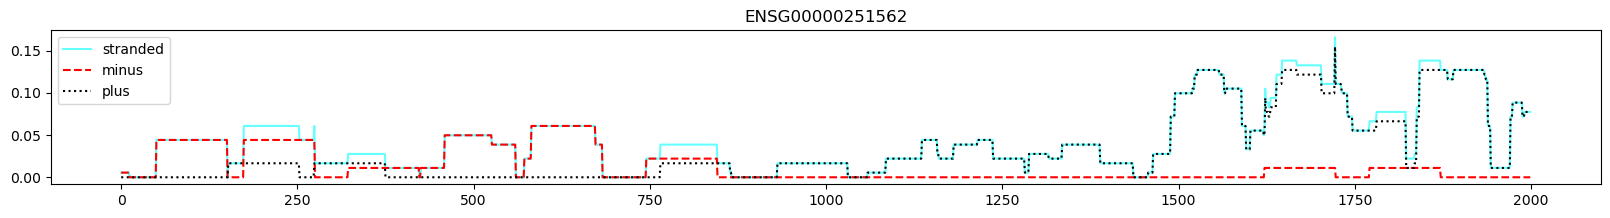

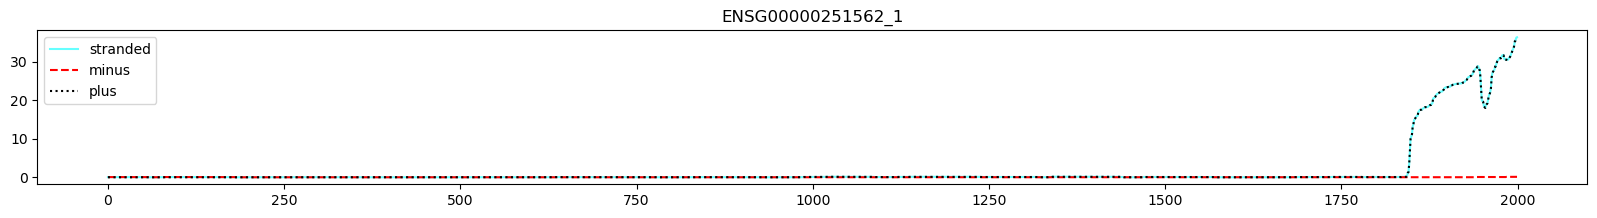

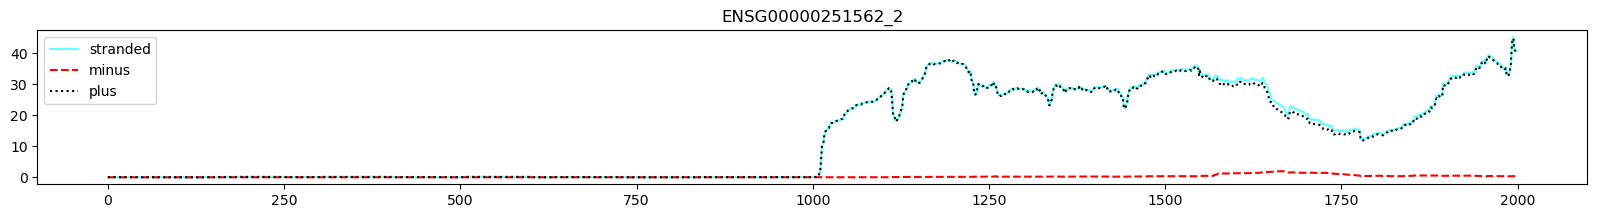

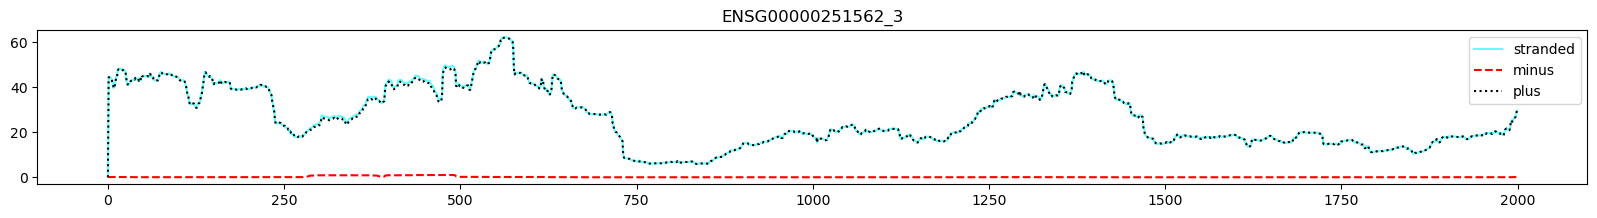

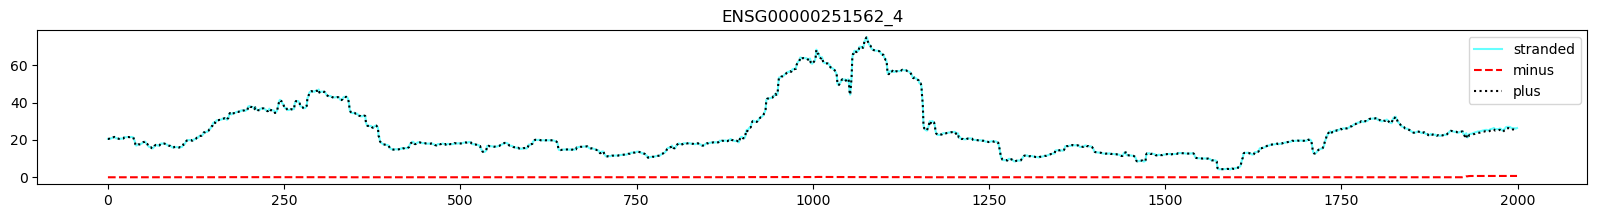

In [168]:
plt.clf()

stranded = []
minus = []
plus = []

for strand_type in [key for key in rna_dict.keys()]:
    gene_gm12878_tss = pd.read_csv('./ABC-multiTSS_nominated/GM12878/Neighborhoods/GeneList.txt', sep='\t')[['name', 'Ensembl_ID', 'chr', 'tss', 'strand', 'H3K27ac.RPM.TSS1Kb', 'DHS.RPM.TSS1Kb']]
    gene_gm12878_tss['ENSID'] = gene_gm12878_tss['Ensembl_ID']

    gene_list_, PE_code_list, PE_distance_list, PE_activity_list, PE_contact_list, rna_df_list = prepare_hd5_input(enhancer_gene_gm12878_100kb_includeNoEnhancerGene, 
                                                                                                                  gene_gm12878_tss, gene_list, 'GM12878', num_features=3, 
                                                                                                                  rna_method='encoding', rna_df=rna_dict[strand_type])
    
    for i, _ in enumerate(gene_list_):
        if strand_type == 'stranded':
            stranded.append(rna_df_list[i])
        elif strand_type == 'minus':
            minus.append(rna_df_list[i])
        elif strand_type == 'plus':
            plus.append(rna_df_list[i])


for i, value in enumerate(gene_list_):
    fig = plt.figure()
    fig.set_size_inches(20, 2) 
    plt.plot(stranded[i], label='stranded', alpha=0.6, color='aqua')
    plt.plot(minus[i], label='minus', linestyle='--', color='red')
    plt.plot(plus[i], label='plus', linestyle=':', color='black')
    plt.title(f"{value}")
    plt.legend()
    plt.show()

In [183]:
!grep {gene} RNA_CAGE.txt

ENSG00000251562	392.956	311.411	0	0	0	0	0	0	0	0	0
ENSG00000251562_1	25.477	42.924	0	0	0	0	0	0	0	0	0
ENSG00000251562_2	174229	83902.5	0	0	0	0	0	0	0	0	0
ENSG00000251562_3	1426.8	674.02	0	0	0	0	0	0	0	0	0
ENSG00000251562_4	465.33	239.82	0	0	0	0	0	0	0	0	0


In [170]:
for i, value in enumerate(stranded):
    print(f"Stranded Minus: {np.array_equal(minus[i], value)}")
    print(f"Stranded Plus: {np.array_equal(plus[i], value)}")
    print(f"Plus Minus: {np.array_equal(plus[i], minus[i])}")

Stranded Minus: False
Stranded Plus: False
Plus Minus: False
Stranded Minus: False
Stranded Plus: False
Plus Minus: False
Stranded Minus: False
Stranded Plus: False
Plus Minus: False
Stranded Minus: False
Stranded Plus: False
Plus Minus: False
Stranded Minus: False
Stranded Plus: False
Plus Minus: False


In [ ]:
for i, gene in enumerate(gene_list):
    plt.plot(rna_df_list[i])
    plt.title(gene)
    plt.show()

In [ ]:
for i, gene in enumerate(gene_list):
    print(f'{gene} - {np.sum(rna_df_list[i])}')

In [ ]:
K562_h5 = h5py.File('/home/witoslaw/data/diffTSS/K562_enhancer_promoter_encoding.rna_encoding.hg38.h5')
GM12878_h5 = h5py.File('/home/witoslaw/data/diffTSS/GM12878_enhancer_promoter_encoding.rna_encoding.hg38.h5')

In [ ]:
rna_signals = K562_h5['rna'][:]

In [ ]:
genes = K562_h5['ensid'][:]
np.sum(rna_signals[np.where(genes == b'ENSG00000143106')])

In [ ]:
rna_df_GM12878

In [ ]:
rna_values = np.array(rna_df_GM12878[[9]]).flatten()
rna_values.shape

In [ ]:
rna_values[np.where(rna_values < 10)].shape[0] / rna_values.shape[0]

In [ ]:
plt.hist(rna_values, bins=30)

In [ ]:
plt.hist(np.tanh(rna_values), bins=30)

In [ ]:
plt.hist(1/ (1 + np.exp(-rna_values)), bins=30)

In [ ]:
plt.hist(np.log10(rna_values+1), bins=30)

In [ ]:
gene_enhancer_table = enhancer_gene_gm12878_100kb_includeNoEnhancerGene
promoter_signals = gene_gm12878_tss
cells = 'GM12878'
num_features = 3
rna_method = 'encoding'
rna_df=rna_df_GM12878

In [ ]:
mRNA_feauture = pd.read_csv('./RNA_CAGE.txt', sep='\t', index_col='ENSID')
promoter_signals['PromoterActivity'] = np.sqrt(promoter_signals['H3K27ac.RPM.TSS1Kb']*promoter_signals['DHS.RPM.TSS1Kb'])
promoter_signals.set_index('ENSID', inplace=True)
mRNA_feats = ['UTR5LEN_log10zscore',
   'CDSLEN_log10zscore', 'INTRONLEN_log10zscore', 'UTR3LEN_log10zscore',
   'UTR5GC', 'CDSGC', 'UTR3GC', 'ORFEXONDENSITY']
PE_code_list = []
#PE_feat_list = []
PE_distance_list = []
PE_activity_list = []
PE_contact_list = []
mRNA_promoter_list = []
PE_links_list = []

In [ ]:
k5_signal_files = [file for file in glob.glob('./RNASeq_bw/K562*coverage.txt')]
k5_signal_files

In [ ]:
gm_signal_files = [file for file in glob.glob('./RNASeq_bw/GM12878*coverage.txt')]
gm_signal_files

In [ ]:
rna_signal_list = []

plt.clf()

cell_type_dict = {'minus':{}, 'plus':{}, 'stranded':{}, 'unstranded':{}}
#gene_dict = {}

for gene in ['ENSG00000089327_2', 'ENSG00000143106', 'ENSG00000213934', 'ENSG00000196565', 'ENSG00000251562_2']:
    for cell_type in cell_type_dict.keys():
        cell_type_dict[cell_type][gene] = []
    for file in tqdm(gm_signal_files, desc=f"{gene}"):
        rna_df = pd.read_csv(file, header=None, sep='\t')
    
        gene_df = gene_enhancer_table[gene_enhancer_table['ENSID'] == gene]

        gene_rna_df = rna_df[rna_df[3] == gene]
        #print(gene_rna_df)

        gene_enhancer_df = gene_df
        fasta_path = './hg38.fa'
        max_n_enhancer = 60
        max_distanceToTSS = 100_000
        max_seq_len=2000
        add_flanking=False

        fasta_extractor = FastaStringExtractor(fasta_path)
        gene_pe = gene_enhancer_df.sort_values(by='distance')
        row_0 = gene_pe.iloc[0]
        gene_ensid=row_0['TargetGeneEnsembl_ID']
        gene_name = row_0['TargetGene']
        gene_tss = row_0['TargetGeneTSS']
        gene_strand = row_0['strand']
        #print(gene_ensid)
        chrom = row_0['chr']
        if row_0['TargetGeneTSS'] != row_0['TargetGeneTSS']:
            gene_tss = row_0['tss']
            gene_name = row_0['name_gene']
            chrom = row_0['chr_gene']
        target_interval = kipoiseq.Interval(chrom, int(gene_tss-max_seq_len/2), int(gene_tss+max_seq_len/2))
        promoter_seq = fasta_extractor.extract(target_interval)
        if gene_strand == '-':
            rc_seq = kipoiseq.transforms.functional.rc_dna(promoter_seq)
            rc_code = one_hot_encode(rc_seq)
        promoter_code = one_hot_encode(promoter_seq)
        gene_len = row_0['end'] - row_0['start']

        rna_signal = gene_rna_df[[9]]
        gene_rna_df = gene_rna_df[(gene_rna_df[7] >= target_interval.start) & (gene_rna_df[8] <= target_interval.end)]
        new_index = gene_rna_df[7].values - target_interval.start
        rna_signal = rna_signal.set_index(new_index).reindex(list(range(0,max_seq_len)), fill_value=0)
        rna_signal = np.array(rna_signal).flatten()
        if gene_strand == '-':
            rna_signal = rna_signal[::-1]
        #print(rna_signal)
        if 'minus' in file:
            cell_type_dict['minus'][gene].append(rna_signal)
        elif 'plus' in file:
            cell_type_dict['plus'][gene].append(rna_signal)
        elif 'unstranded' in file:
            cell_type_dict['unstranded'][gene].append(rna_signal)
        else:
            cell_type_dict['stranded'][gene].append(rna_signal)
        #rna_signal_list.append(rna_signal)
        
for cell_type in cell_type_dict.keys():
    for gene in cell_type_dict[cell_type].keys():
        cell_type_dict[cell_type][gene] = np.array(cell_type_dict[cell_type][gene])

In [ ]:
plot_dict = {}
for gene in ['ENSG00000089327_2', 'ENSG00000143106', 'ENSG00000213934', 'ENSG00000196565', 'ENSG00000251562_2']:
    plot_dict[gene] = {}


for cell_type in cell_type_dict.keys():
    for gene in cell_type_dict[cell_type].keys():
        plot_dict[gene][cell_type] = cell_type_dict[cell_type][gene]

for gene in plot_dict.keys():
    for cell_type in plot_dict[gene].keys():
        #if cell_type == 'stranded':
            #plot_dict[gene][cell_type] = np.log10(plot_dict[gene][cell_type]+1)
            #continue
        plt.plot(np.sum(plot_dict[gene][cell_type], axis=0), label=cell_type)
        plt.xlabel("Promoter Position")
        plt.ylabel("RNA Signal")
        plt.title(f"GM12878 Coverage of {gene}")
        plt.legend()
    plt.show()


In [ ]:
gene_tss

In [ ]:
gene_rna_df[[7]][224:350] - gene_tss

In [ ]:
rna_signal[735:856]

In [ ]:
promoter_code

In [ ]:
rc_code

In [ ]:
rc_rna_signal

In [ ]:
promoter_seq

In [ ]:
rc_seq

In [ ]:
gene_strand

In [ ]:
np.array(rna_signal)

In [ ]:
mean_signal = np.mean(np.array(rna_signal_list), axis=0)
mean_signal

In [ ]:
mean_signal.shape

In [ ]:
for gene in gene_list[0:10]:
    print(gene)

In [ ]:
gene_enhancer_table

In [ ]:
if rna_method == 'encoding':
    gene_len = row_0['end'] - row_0['start']
    rna_signal = rna_df[[9]]
    rna_df = rna_df[(rna_df[7] >= target_interval.start) & (rna_df[8] <= target_interval.end)]
    new_index = rna_df[7].values - target_interval.start
    rna_signal = rna_signal.set_index(new_index).reindex(list(range(0,max_seq_len)), fill_value=0)
    
    #rna_signal = rna_signal.apply(lambda x: np.exp(-x))
    #promoter_code = np.concatenate((promoter_code, rna_signal), axis=1)     
    
#promoter_code
rna_signal

In [ ]:
rna_signal.index

In [ ]:
rna_df[(rna_df[7] >= target_interval.start) & (rna_df[8] <= target_interval.end)]

In [ ]:
new_index = rna_df[7].values - target_interval.start

In [ ]:
gene_len = row_0['end'] - row_0['start']
rna_signal = rna_df[[9]]
rna_df = rna_df[(rna_df[7] >= target_interval.start) & (rna_df[8] <= target_interval.end)]
rna_df

In [ ]:
new_index = rna_df[7].values - target_interval.start
new_index

In [ ]:
rna_signal = rna_signal.set_index(new_index).reindex(list(range(0,max_seq_len)), fill_value=0)
rna_signal

In [ ]:
np.concatenate((promoter_code, rna_signal), axis=1)

In [ ]:
promoter_code.shape

In [ ]:
np.exp(-np.exp(-0.07))

In [ ]:
promoter_code[:, 4].min()

In [ ]:
if rna_embedding:
    rna_df = np.concatenate([rna_df.reshape(1, 125), np.zeros([60, 125])])
enhancers_code = np.zeros((max_n_enhancer, max_seq_len, 4))
enhancer_activity = np.zeros(max_n_enhancer)
enhancer_distance = np.zeros(max_n_enhancer)
enhancer_contact = np.zeros(max_n_enhancer)
# set distance threshold
gene_pe = gene_pe[(gene_pe['distance'] > max_seq_len/2)&(gene_pe['distance'] <= max_distanceToTSS)]
e_i = 0
gene_element_pair = []
for idx, row in gene_pe.iterrows():
    if row['TargetGene'] != row['TargetGene']:
        break
    if pd.isna(row['start']):
        continue
    if e_i >= max_n_enhancer:
        break
    enhancer_start = int(row['start'])
    enhancer_end = int(row['end'])
    enhancer_center = int((row['start'] + row['end'])/2)
    enhancer_len = enhancer_end - enhancer_start
    # put sequence at the center
    if add_flanking:
        enhancer_target_interval = kipoiseq.Interval(chrom, enhancer_center-int(max_seq_len/2), enhancer_center+int(max_seq_len/2))
        enhancers_code[e_i][:] = one_hot_encode(fasta_extractor.extract(enhancer_target_interval))
    else:
        # enhancers_signal = np.zeros((max_n_enhancer, max_seq_len))
        if enhancer_len > max_seq_len:
            enhancer_target_interval = kipoiseq.Interval(chrom, enhancer_center-int(max_seq_len/2), enhancer_center+int(max_seq_len/2))
            enhancers_code[e_i][:] = one_hot_encode(fasta_extractor.extract(enhancer_target_interval))
        else:
            code_start = int(max_seq_len/2)-int(enhancer_len/2)
            enhancer_target_interval = kipoiseq.Interval(chrom, enhancer_start, enhancer_end)
            enhancers_code[e_i][code_start:code_start+enhancer_len] = one_hot_encode(fasta_extractor.extract(enhancer_target_interval))
    # put sequence from the start
    enhancer_activity[e_i] = row['activity_base']
    enhancer_distance[e_i] = row['distance']
    enhancer_contact[e_i] = row['hic_contact']
    gene_element_pair.append([gene_name, row['name']])
    e_i += 1

In [ ]:
enhancers_code[0]

In [ ]:
# print(promoter_signals.shape, enhancers_signal.shape)
if rna_encoding:
    enhancers_code = np.concatenate((enhancers_code, np.zeros((max_n_enhancer, max_seq_len, 1))), axis=2)
    pe_code = np.concatenate([promoter_code[np.newaxis,:], enhancers_code], axis=0, dtype=np.float32)
else:
    pe_code = np.concatenate([promoter_code[np.newaxis,:], enhancers_code], axis=0)
gene_element_pair = pd.DataFrame(gene_element_pair, columns=['gene', 'element'])
if rna_embedding:
    return pe_code, enhancer_activity, enhancer_distance, enhancer_contact, gene_name, gene_element_pair, rna_df
return pe_code, enhancer_activity, enhancer_distance, enhancer_contact, gene_name, gene_element_pair


contact_list = np.concatenate([[0], contact_list])
distance_list = np.concatenate([[0], distance_list/1000])
activity_list = np.concatenate([[0], activity_list])
# activity_list = np.log10(0.1+activity_list)
contact_list = np.log10(1+contact_list)
try:
    gene_mRNA_feature = mRNA_feauture.loc[gene, mRNA_feats]
except KeyError:
    dummy_mRNA_feature = pd.DataFrame(columns=mRNA_feats)
    dummy_mRNA_feature.loc[0] = [None]*len(mRNA_feats)
    gene_mRNA_feature = dummy_mRNA_feature.loc[0]
mRNA_promoter_feat = np.array(list(gene_mRNA_feature.values) + [promoter_signals.loc[gene, 'PromoterActivity']])
#if num_features == 1:
#    PE_feat = distance_list[:,np.newaxis]
#    mRNA_promoter_feat = np.array(list(gene_mRNA_feature.values) + [0])
#elif num_features == 2:
#    PE_feat = np.concatenate([distance_list[:,np.newaxis], activity_list[:,np.newaxis], ],axis=-1)
#else:
#    PE_feat = np.concatenate([distance_list[:,np.newaxis], contact_list[:,np.newaxis], activity_list[:,np.newaxis], ],axis=-1)
# print(gene_name, PE_code.shape, PE_feat.shape, mRNA_promoter_feat.shape)
PE_code_list.append(PE_code)
#PE_feat_list.append(PE_feat)
PE_distance_list.append(distance_list)
PE_activity_list.append(activity_list)
PE_contact_list.append(contact_list)
mRNA_promoter_list.append(mRNA_promoter_feat)
PE_links_list.append(PE_links)